### Installing Dependencies

In [1]:
# Python version 3.13.0
!pip install numpy==2.1.2
!pip install pandas==2.2.3
!pip install matplotlib==3.9.2
!pip install scipy==1.14.1
!pip install statsmodels==0.14.4
!pip install scikit-learn
!pip install xgboost


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming 'data' is your time series
# sm.graphics.tsa.plot_acf(data, lags=40)
# sm.graphics.tsa.plot_pacf(data, lags=40)
# plt.show()


### Fetching table names from a .db3 sqlite file

In [3]:
def get_table_names(db_dir: str):
    try:
        conn = sqlite3.connect(db_dir)
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        print("Tables in the database:", tables)


    except sqlite3.Error as e:
        print(f"An error occurred: {e}")

    finally:
        if conn:
            conn.close()

db_dir = '../Data/Babylyn Grocery/History.db3'
get_table_names(db_dir)

Tables in the database: [('sqlite_sequence',), ('CardInfo',), ('PaidOut',), ('ProductHistory',), ('TransactionLog',)]


### Fetching data from a .db3 sqlite file and making it into a dataframe

In [4]:
def fetch_table_to_pd(db_dir: str, table: str):
    try:
        conn = sqlite3.connect(db_dir)
        df = pd.read_sql_query(f'SELECT * FROM {table}', conn)

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")

    finally:
        if conn:
            conn.close()
    return df

table = 'TransactionLog'
data_raw = fetch_table_to_pd(db_dir, table)
data_raw['Date'] = pd.to_datetime(data_raw['TransactionDate'] + ' ' + data_raw['TransactionTime'] + ':00')
data_raw = data_raw.set_index('Date')

**Removing the refunded transactions**\
Using DB Browser (Sqlite), there are datapoints in 'TransactionNumber' that looks like 102374, 102374-(Void). Looking closely, this signifies that the purchase 102374 was refunded. Hence both rows with the corresponding 'TransactionNumber should be removed.

In [5]:
# Step 1: Create a new column with the core transaction number (without '-(Void)')
data_raw['CoreTransaction'] = data_raw['TransactionNumber'].str.replace(r'-(Void)', '', regex=True)

# Step 2: Remove 'duplicate' TransactionNumbers (both purchase and refund entries)
duplicate_transactions = data_raw[data_raw.duplicated('CoreTransaction', keep=False)]

# Step 3: Remove both purchase and refund entries
data_raw = data_raw.drop(duplicate_transactions.index)

### Getting non-null and relevant columns

In [6]:
data = data_raw[['TransactionNumber','TransactionDate', 'TransactionTime', 'SalesTotal']]
# data = data[data['TransactionNumber'].str.len() == 6]

data['Date'] = pd.to_datetime(data['TransactionDate'] + ' ' + data['TransactionTime'] + ':00')
data = data.set_index('Date')

# Aggregating data by day
data = data.resample('D').sum()
data = data.asfreq('D', method='ffill')

# Create a new column for the daily frequency of sales
frequency = data_raw[data_raw.index >= '2021-01-01'].resample("D").count()['TransactionNumber']
frequency = frequency.rename('SalesFrequency')
data = pd.concat([data, frequency], axis=1)



D:\Temp\ipykernel_10256\3475298132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['TransactionDate'] + ' ' + data['TransactionTime'] + ':00')


**Splitting the data into the startup and operational phase** \
Since the data's time frame was from the grocery store's inception, the sales behaviour from it's startup phase might be different from the operational phase.
Since the sales data before 2021 shows a lot more iregularity and instability, we will consider that period to be the startup phase and the sales data after 2021 the operational phase.

(array([18628., 18809., 18993., 19174., 19358., 19539., 19723., 19905.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07'),
  Text(19723.0, 0, '2024-01'),
  Text(19905.0, 0, '2024-07')])

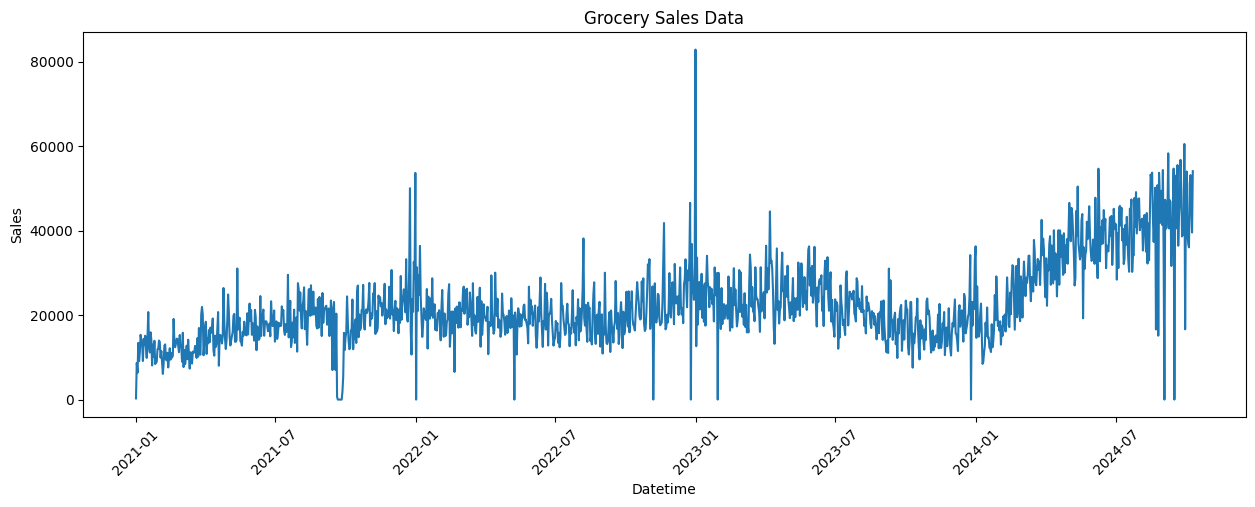

In [7]:
startup_data = data[data.index < '2021-01-01']
data = data[data.index >= '2021-01-01']

sales_data = data['SalesTotal']
sales_data = sales_data[:len(sales_data)-1]

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(sales_data.index, sales_data)
plt.xlabel('Datetime')
plt.ylabel('Sales')
plt.title("Grocery Sales Data")
plt.xticks(rotation = 45)


### Features that will be considered for weekly model(biweekly/monthly) of SalesTotal
**Lags:** 1 yr, 1 month, 5 weeks before (1 yr, 1 month, 3 biweeks before/1 yr, 3 months before)
**Economic Indicators (Linearly interpolated if needed):** 
- GDP (Linearly Interpolated)
- inflation
- consumer price index
- unemployment rate
- Holidays (Binary)
- Lagged Exogenous Events (Binary)
- Expected Exogenous Events (Binary)
- Lagged Days Closed (Positive integers incl. 0)
- Expected Days Closed (Positive integers incl. 0)

### Creating the exogenous events feature
Much like most family-owned grocery stores, Babylyn's grocery store is integrated in their house and the owner stated that they had a renovation for the house around July 2023 to December 2023, affecting their sales. Thus we want to capture that in our data.

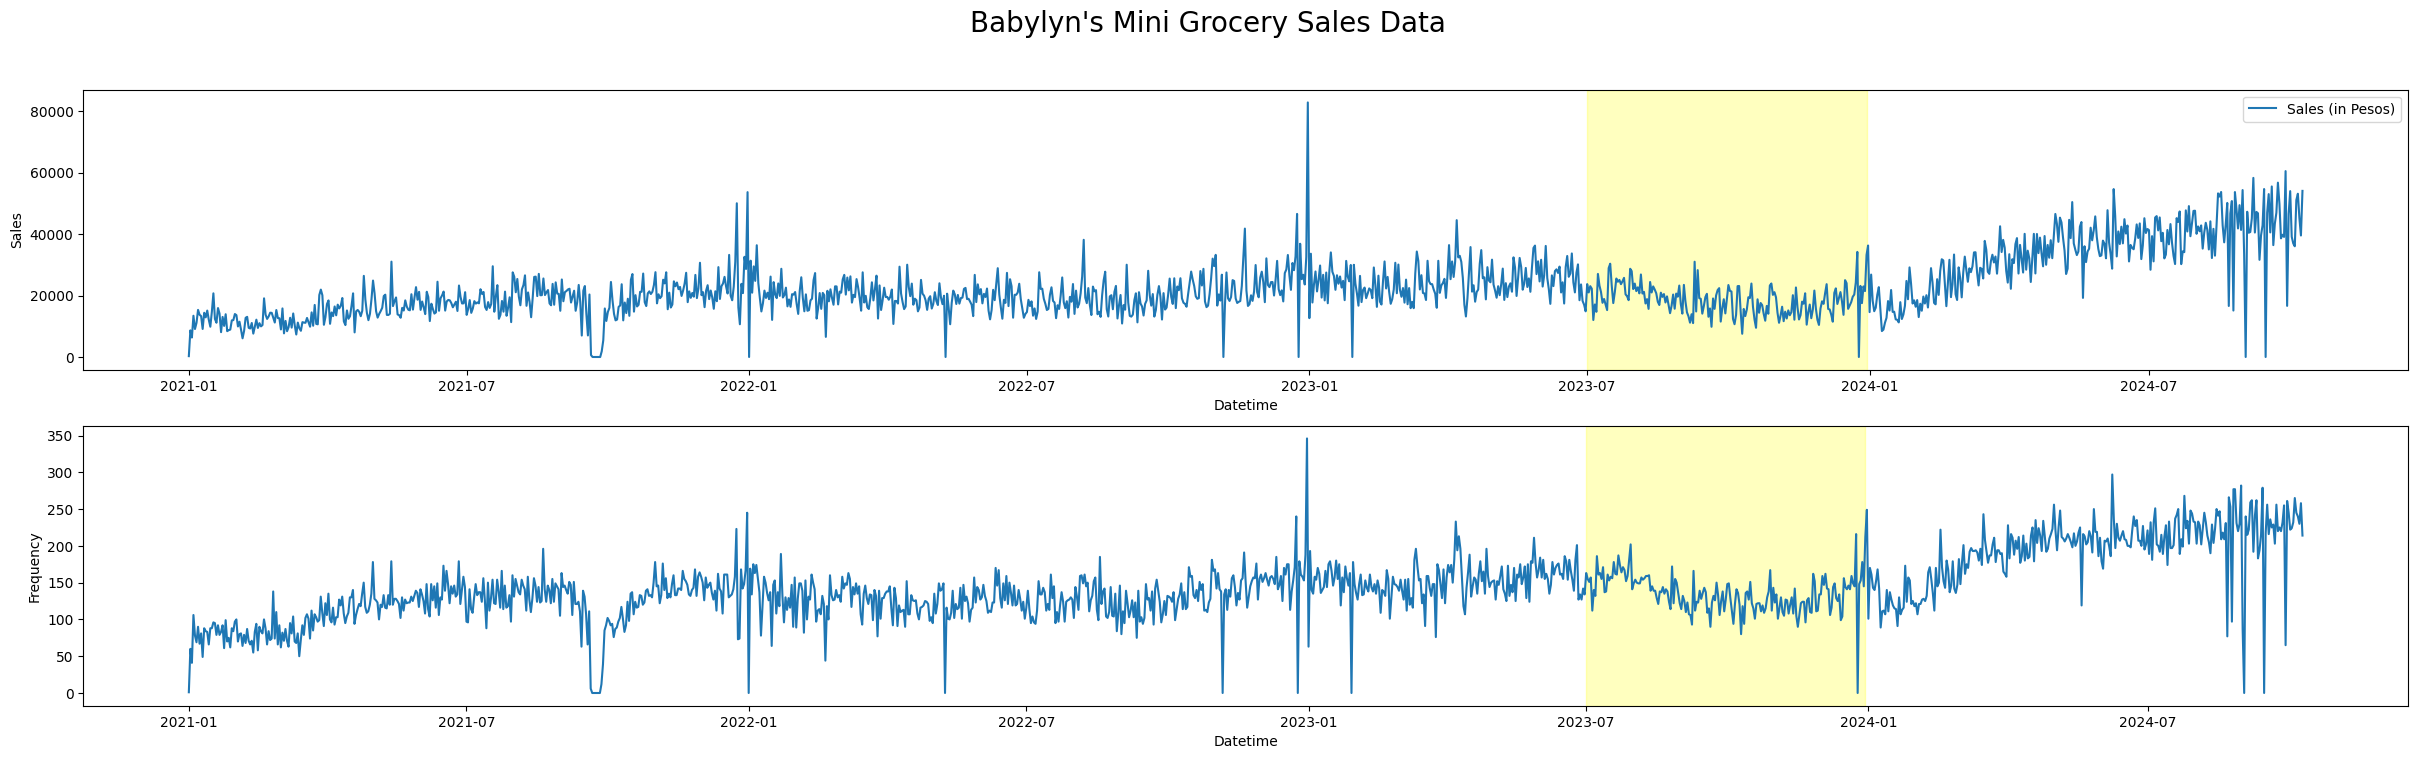

In [8]:
data["Renovation"] = np.zeros(len(data))
data["Renovation"] = data["Renovation"].mask(
    (data.index >= '2023-07-01') & (data.index <= '2023-12-30'), 1
)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 8))
fig.suptitle("Babylyn's Mini Grocery Sales Data", fontsize=20)
axes[0].plot(sales_data.index, sales_data, label = "Sales (in Pesos)")
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('Sales')
axes[0].legend()
axes[1].plot(data["SalesFrequency"].index, data["SalesFrequency"], label = "Frequency of Sales")
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Frequency')
axes[0].legend()
axes[0].axvspan(pd.to_datetime('2023-07-01'), pd.to_datetime('2023-12-30'), color='yellow', alpha=0.25)
axes[1].axvspan(pd.to_datetime('2023-07-01'), pd.to_datetime('2023-12-30'), color='yellow', alpha=0.25)

plt.show()


### Creating the Days Closed feature
We want to know how closures and the duration of closures affect the sales. We will consider the store closed for the whole day if it has less than 3 sales since it will be very unlikely for a grocery store to be open the majority of the day and only get less than 3 sales.

In [9]:
# Create a new column that contains a 1 if the grocery is closed
data["isClosed"] = np.zeros(len(data))
data["isClosed"] = data["isClosed"].mask(
    data["SalesFrequency"] <= 3, 1
)
data[data["isClosed"] == 1].head()

,TransactionNumber,TransactionDate,TransactionTime,SalesTotal,SalesFrequency,Renovation,isClosed
Date,,,,,,,
2021-01-01,111155,2021-01-01,15:44,276.0,1.0,0.0,1.0
2021-09-21,0,0,0,0.0,0.0,0.0,1.0
2021-09-22,0,0,0,0.0,0.0,0.0,1.0
2021-09-23,0,0,0,0.0,0.0,0.0,1.0
2021-09-24,0,0,0,0.0,0.0,0.0,1.0


In [10]:
data['DayClosed'] = np.zeros(len(data))
data.at['2021-01-01', 'DayClosed'] = 1
for idx, row in data[1:].iterrows():
    if int(row['isClosed']) == 1:
        data.at[idx, 'DayClosed'] = 1 + int(data.loc[idx - pd.Timedelta(days=1), 'DayClosed'])
data[data["isClosed"] == 1].head(5)

,TransactionNumber,TransactionDate,TransactionTime,SalesTotal,SalesFrequency,Renovation,isClosed,DayClosed
Date,,,,,,,,
2021-01-01,111155,2021-01-01,15:44,276.0,1.0,0.0,1.0,1.0
2021-09-21,0,0,0,0.0,0.0,0.0,1.0,1.0
2021-09-22,0,0,0,0.0,0.0,0.0,1.0,2.0
2021-09-23,0,0,0,0.0,0.0,0.0,1.0,3.0
2021-09-24,0,0,0,0.0,0.0,0.0,1.0,4.0


### Creating the holiday feature
Source: https://www.officialgazette.gov.ph/nationwide-holidays/\
Days with holidays have values 1 and 0 otherwise.

In [11]:
def get_holiday(holiday_dir):
    holiday = pd.read_csv(holiday_dir)
    holiday['Holidays'] = pd.to_datetime(holiday['Holidays'])
    return holiday

holiday_dir = '../Data/ExternalFactorsData/Holidays.csv'
holiday = get_holiday(holiday_dir)
holiday.head()

,Holidays
0,2021-01-01
1,2021-04-09
2,2021-04-01
3,2021-04-02
4,2021-05-01


In [12]:
data['isHoliday'] = np.zeros(len(data))
data['isHoliday'] = data['isHoliday'].mask(
    data.index.isin(holiday['Holidays']), 1
)
data[data['isHoliday'] == 1].head()

,TransactionNumber,TransactionDate,TransactionTime,SalesTotal,SalesFrequency,Renovation,isClosed,DayClosed,isHoliday
Date,,,,,,,,,
2021-01-01,111155,2021-01-01,15:44,276.00,1.0,0.0,1.0,1.0,1.0
2021-02-12,1143701143711143721143731143741143751143761143...,2021-02-122021-02-122021-02-122021-02-122021-0...,09:0509:2909:3510:0610:1211:2011:2111:2411:341...,7605.00,55.0,0.0,0.0,0.0,1.0
2021-02-25,1153921153931153941153951153961153971153981153...,2021-02-252021-02-252021-02-252021-02-252021-0...,08:4808:5208:5709:0109:1609:3810:1110:1810:451...,12754.55,138.0,0.0,0.0,0.0,1.0
2021-04-01,1184891184901184911184921184931184941184951184...,2021-04-012021-04-012021-04-012021-04-012021-0...,07:0107:1007:2707:2907:2907:4507:5007:5407:560...,17248.25,106.0,0.0,0.0,0.0,1.0
2021-04-02,1185931185941185951185961185971185981185991186...,2021-04-022021-04-022021-04-022021-04-022021-0...,06:4906:5406:5607:0507:2707:5307:5407:5507:560...,18411.20,135.0,0.0,0.0,0.0,1.0


### Creating lags

In [13]:
data['Lag1'] = data['SalesFrequency'].shift(1)
data['Lag2'] = data['SalesFrequency'].shift(2)
data['Lag3'] = data['SalesFrequency'].shift(3)
data['Lag4'] = data['SalesFrequency'].shift(4)
data['Lag5'] = data['SalesFrequency'].shift(5)
data['Lag6'] = data['SalesFrequency'].shift(6)
data['Lag7'] = data['SalesFrequency'].shift(7)
data

,TransactionNumber,TransactionDate,TransactionTime,SalesTotal,SalesFrequency,Renovation,isClosed,DayClosed,isHoliday,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7
Date,,,,,,,,,,,,,,,,
2021-01-01,111155,2021-01-01,15:44,276.00,1.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,111155-(Void)111156111157111158111159111160111...,2021-01-022021-01-022021-01-022021-01-022021-0...,08:2108:2408:2708:2808:3208:3509:0409:0809:110...,8664.70,60.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,1112151112161112171112181112191112201112211112...,2021-01-032021-01-032021-01-032021-01-032021-0...,14:3114:3614:4314:5215:2815:2815:3715:4215:491...,6342.50,41.0,0.0,0.0,0.0,0.0,60.0,1.0,NaN,NaN,NaN,NaN,NaN
2021-01-04,111256111256-(Void)111257111258111259111260111...,2021-01-042021-01-042021-01-042021-01-042021-0...,08:1708:1708:1808:1808:3308:5309:0109:1309:140...,13422.55,106.0,0.0,0.0,0.0,0.0,41.0,60.0,1.0,NaN,NaN,NaN,NaN
2021-01-05,1113611113621113631113641113651113661113671113...,2021-01-052021-01-052021-01-052021-01-052021-0...,08:0608:1208:4008:4309:0310:0610:1810:2510:321...,9098.50,78.0,0.0,0.0,0.0,0.0,106.0,41.0,60.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-06,3067623067633067643067653067663067673067683067...,2024-10-062024-10-062024-10-062024-10-062024-1...,08:3708:3908:4108:4208:4308:4408:4608:5008:530...,53127.48,245.0,0.0,0.0,0.0,0.0,265.0,232.0,224.0,222.0,245.0,261.0,65.0
2024-10-07,3070063070073070083070093070103070113070123070...,2024-10-072024-10-072024-10-072024-10-072024-1...,08:1408:1708:2008:2408:2508:4208:4308:4608:470...,45199.22,240.0,0.0,0.0,0.0,0.0,245.0,265.0,232.0,224.0,222.0,245.0,261.0
2024-10-08,3072463072473072483072493072503072513072523072...,2024-10-082024-10-082024-10-082024-10-082024-1...,07:5407:5508:0108:0808:1108:2708:2908:2908:320...,39542.75,230.0,0.0,0.0,0.0,0.0,240.0,245.0,265.0,232.0,224.0,222.0,245.0


In [14]:
cpi = pd.read_csv('../Data/ExternalFactorsData/cpi2124.csv')
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi = cpi.set_index('Date')
inflation = pd.read_csv('../Data/ExternalFactorsData/inflation2024.csv')
inflation['Date'] = pd.to_datetime(inflation['Date'])
inflation = inflation.set_index('Date')
gni = pd.read_csv('../Data/ExternalFactorsData/gni2124q.csv')
gni['Date'] = pd.to_datetime(gni['Date'])
gni = gni.set_index('Date')

In [15]:
data = pd.concat([data, cpi, inflation, gni], axis=1)
data['AllCPI'] = data['AllCPI'].interpolate(method='linear')
data['FoodDrinksCPI'] = data['FoodDrinksCPI'].interpolate(method='linear')
data['InflationRate'] = data['InflationRate'].interpolate(method='linear')
data['GNI'] = data['GNI'].interpolate(method='linear')
data = data[(data.index >= '2021-01-08') & (data.index <= '2024-09-01')]
data.head()

,TransactionNumber,TransactionDate,TransactionTime,SalesTotal,SalesFrequency,Renovation,isClosed,DayClosed,isHoliday,Lag1,...,Lag3,Lag4,Lag5,Lag6,Lag7,AllCPI,FoodDrinksCPI,InflationRate,GNI,GNI_Lag
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-08,1115961115971115981115991116001116011116021116...,2021-01-082021-01-082021-01-082021-01-082021-0...,09:0209:3109:3210:1010:2110:2311:0011:0211:131...,13751.55,67.0,0.0,0.0,0.0,0.0,90.0,...,78.0,106.0,41.0,60.0,1.0,108.422581,110.609677,3.812903,4.956533e+06,NaN
2021-01-09,1116631116641116651116661116671116681116691116...,2021-01-092021-01-092021-01-092021-01-092021-0...,08:3408:3608:3808:4708:4908:5208:5409:0809:090...,13314.70,81.0,0.0,0.0,0.0,0.0,67.0,...,69.0,78.0,106.0,41.0,60.0,108.425806,110.596774,3.829032,4.945358e+06,NaN
2021-01-10,1117441117451117461117471117481117491117501117...,2021-01-102021-01-102021-01-102021-01-102021-0...,15:1015:1215:1415:1415:2815:3615:4015:4315:541...,9129.00,49.0,0.0,0.0,0.0,0.0,81.0,...,90.0,69.0,78.0,106.0,41.0,108.429032,110.583871,3.845161,4.934184e+06,NaN
2021-01-11,1117931117941117951117961117971117981117991118...,2021-01-112021-01-112021-01-112021-01-112021-0...,07:4808:0608:1108:1508:2008:2208:2308:3908:450...,14391.10,88.0,0.0,0.0,0.0,0.0,49.0,...,67.0,90.0,69.0,78.0,106.0,108.432258,110.570968,3.861290,4.923009e+06,NaN
2021-01-12,1118811118821118831118841118851118861118871118...,2021-01-122021-01-122021-01-122021-01-122021-0...,08:2108:2708:3409:0109:2509:3309:4309:5510:271...,12894.50,84.0,0.0,0.0,0.0,0.0,88.0,...,81.0,67.0,90.0,69.0,78.0,108.435484,110.558065,3.877419,4.911834e+06,NaN


In [16]:
final_data = data[['SalesFrequency', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7', 'DayClosed', 'isHoliday', 'AllCPI', 'FoodDrinksCPI', 'InflationRate', 'GNI']]
final_data.head()

,SalesFrequency,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,DayClosed,isHoliday,AllCPI,FoodDrinksCPI,InflationRate,GNI
Date,,,,,,,,,,,,,,
2021-01-08,67.0,90.0,69.0,78.0,106.0,41.0,60.0,1.0,0.0,0.0,108.422581,110.609677,3.812903,4.956533e+06
2021-01-09,81.0,67.0,90.0,69.0,78.0,106.0,41.0,60.0,0.0,0.0,108.425806,110.596774,3.829032,4.945358e+06
2021-01-10,49.0,81.0,67.0,90.0,69.0,78.0,106.0,41.0,0.0,0.0,108.429032,110.583871,3.845161,4.934184e+06
2021-01-11,88.0,49.0,81.0,67.0,90.0,69.0,78.0,106.0,0.0,0.0,108.432258,110.570968,3.861290,4.923009e+06
2021-01-12,84.0,88.0,49.0,81.0,67.0,90.0,69.0,78.0,0.0,0.0,108.435484,110.558065,3.877419,4.911834e+06


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
X = final_data[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7', 'DayClosed', 'isHoliday', 'AllCPI', 'FoodDrinksCPI', 'InflationRate', 'GNI']]
Y = final_data['SalesFrequency']

# Split the data into training and testing sets
X_train = X[X.index < '2024-07-01']
X_test = X[X.index >= '2024-07-01']
Y_train = Y[Y.index < '2024-07-01']
Y_test = Y[Y.index >= '2024-07-01']

# Keep track of indices
train_indices = X_train.index
test_indices = X_test.index

# Convert to NumPy arrays
X_train_np = X_train.values
Y_train_np = Y_train.values
X_test_np = X_test.values
Y_test_np = Y_test.values

In [19]:
# Initialize the XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, early_stopping_rounds=50)

# Train the model
model.fit(X_train_np, Y_train_np,
          eval_set=[(X_train_np, Y_train_np),
         (X_test_np, Y_test_np)],
         verbose=10
         )

[0]	validation_0-rmse:30.64064	validation_1-rmse:70.84963
[10]	validation_0-rmse:14.41065	validation_1-rmse:53.04748
[20]	validation_0-rmse:10.87059	validation_1-rmse:53.07757
[30]	validation_0-rmse:9.17797	validation_1-rmse:53.31598
[40]	validation_0-rmse:7.26530	validation_1-rmse:53.03068
[50]	validation_0-rmse:5.96895	validation_1-rmse:53.69565
[60]	validation_0-rmse:4.83853	validation_1-rmse:53.63213
[69]	validation_0-rmse:3.88393	validation_1-rmse:53.59551


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

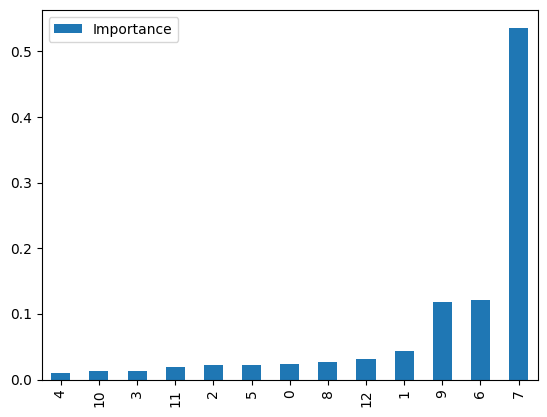

In [20]:
pd.DataFrame(data = model.feature_importances_, columns = ['Importance']).sort_values('Importance').plot(kind = 'bar')

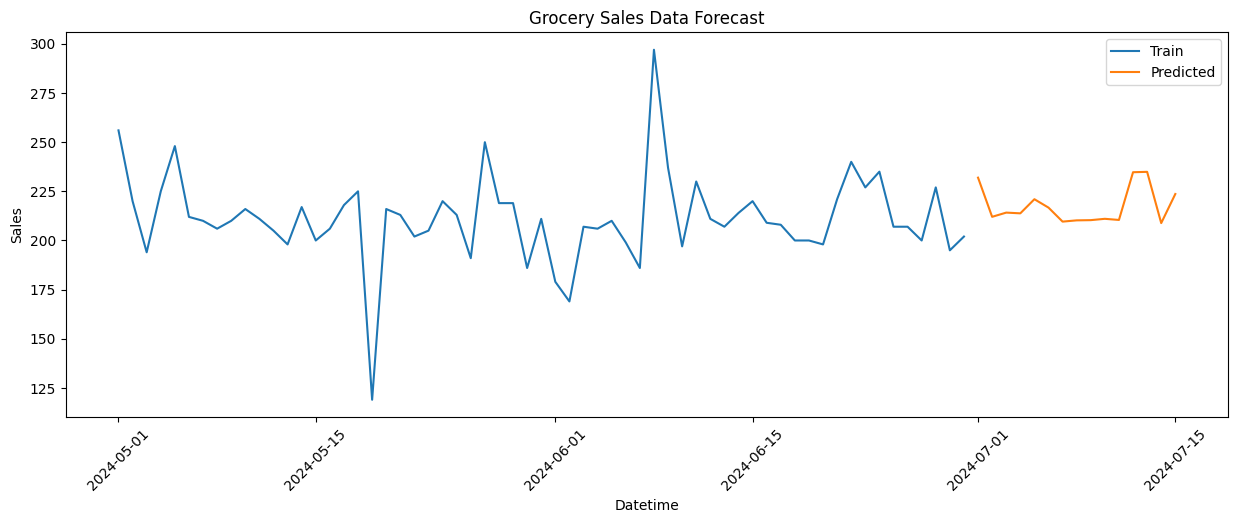

In [21]:
pred = model.predict(X_test_np[:15])

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(Y_train[Y_train.index >= '2024-05-01'], label = 'Train')
# plt.plot(Y_test[:15], label = 'Test')
plt.plot(pd.DataFrame(pred, index = Y_test.index[:15]), label = 'Predicted')
plt.xlabel('Datetime')
plt.ylabel('Sales')
plt.title("Grocery Sales Data Forecast")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

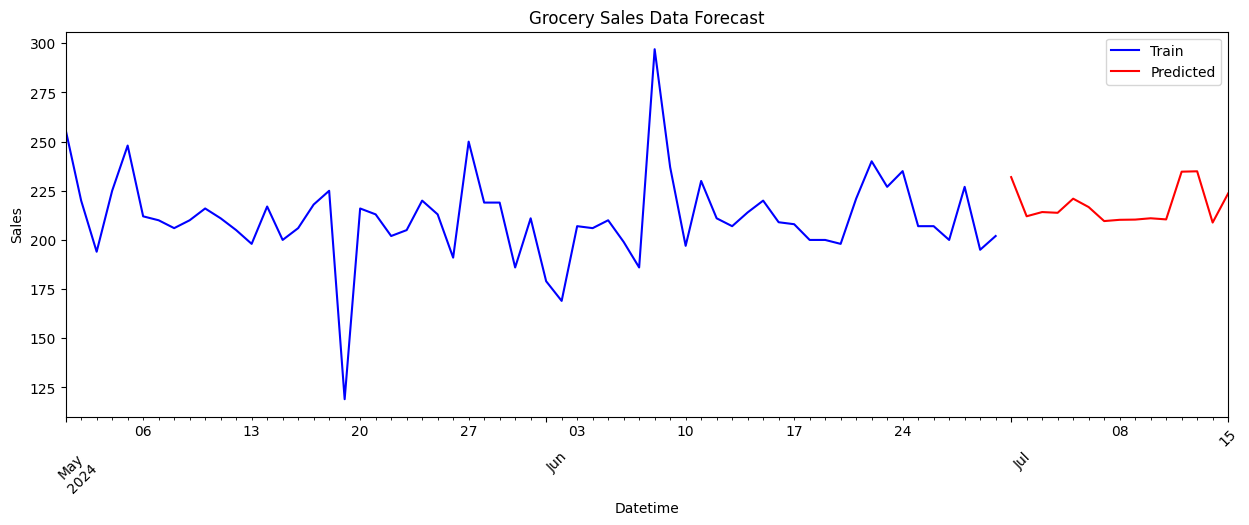

In [26]:
# Generate predictions for the first 15 test samples
pred = model.predict(X_test_np[:15])

# Create a DataFrame for predictions with the same index as Y_test[:15]
pred_df = pd.DataFrame(pred, index=Y_test.index[:15], columns=['Predicted'])

# Combine the train, test, and predicted data for easy plotting
combined_df = pd.concat([
    Y_train[Y_train.index >= '2024-05-01'],  # Train data from a specific date
    pred_df  # Corresponding predictions
], axis=1)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
combined_df['SalesFrequency'].plot(ax=ax, label='Train', color='blue')  # Train data
combined_df['Predicted'].plot(ax=ax, label='Predicted', color='red')  # Predictions

# Formatting the plot
plt.xlabel('Datetime')
plt.ylabel('Sales')
plt.title("Grocery Sales Data Forecast")
plt.xticks(rotation=45)
plt.legend()
plt.show()
# combined_df


In [28]:
combined_df.to_csv('forecast.csv')

In [29]:
combined_df

,SalesFrequency,Predicted
Date,,
2024-05-01,256.0,NaN
2024-05-02,220.0,NaN
2024-05-03,194.0,NaN
2024-05-04,225.0,NaN
2024-05-05,248.0,NaN
...,...,...
2024-07-11,NaN,210.444229
2024-07-12,NaN,234.715912
2024-07-13,NaN,234.910156
